## Portfolio Optimisation

In this notebook I will give a brief overview of portfolio optimisation. Portfolio optimisation is the practice of selecting the best set of assets to match a given goal. Modern Portfolio Theory (MPT) was born out of a dissertation  written by Harry Markowitz in 1952. In his seminal paper Markowitz set out the theory on how to construct portfolios that maximise the return for any given risk. Risk was measured as the standard deviation, or volitility, of the returns. 

I will first construct a minimum-variance frontier using plain old Python code. This will provide an understanding on the basics of constructing an optimised portfolio. I will then give an overview of Pyportfolioopt, which is a Python package for portfolio optimisation.

In [2]:
# import packages used in this notebook
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt
import scipy.optimize as solver
from pypfopt import expected_returns 
from pypfopt import risk_models
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt import base_optimizer

### Manually calculate components of the Efficient Frontier
The efficient frontier is an important concept in MPT. Portfolios on the Efficient Frontier are considered to be optimised for the given risk, or return.  
First, read data for the assets that can make up the portfolio. For demonstration purposes I shall keep the dataset small and only use about five years of data.

In [3]:
start_date = '2015-01-01'
end_date = dt.datetime.now()

assets = ['GOOG','MSFT','CSCO','AMZN','C','TSLA','GS','XOM','BP']
data = pd.DataFrame(columns=assets)
for asset in assets:
    data[asset] = web.DataReader(asset,'yahoo',start=start_date,end=end_date)['Adj Close']

# number of assets
n_assets = len(assets)
    
# view the start of the data
data.head()

,GOOG,MSFT,CSCO,AMZN,C,TSLA,GS,XOM,BP
Date,,,,,,,,,
2015-01-02,523.373108,41.539135,22.964809,308.519989,48.313530,43.862000,177.056488,70.862823,25.638012
2015-01-05,512.463013,41.157158,22.507343,302.190002,46.790939,42.018002,171.528290,68.923904,24.279436
2015-01-06,500.585632,40.553074,22.499020,295.290009,45.143681,42.256001,168.058380,68.557472,24.097849
2015-01-07,499.727997,41.068310,22.706963,298.420013,45.562168,42.189999,170.562881,69.252136,24.158375
2015-01-08,501.303680,42.276463,22.881630,300.459991,46.247784,42.124001,173.286011,70.404800,24.703152


We do not expect to have to do any preprocessing on the data but it is good proactice to perform a quick check to see if there are any NANs.  

In [4]:
data.isnull().values.any()

False

Get the annualised returns of each asset and the covariance matrix of the returns

In [5]:
discrete_returns = np.array(data[assets].pct_change()[1:])
cov_matrix = np.asmatrix(np.cov(discrete_returns.T)) 
asset_returns = discrete_returns.mean(axis=0) * 252

print(asset_returns)

[ 0.24311641  0.31680778  0.13565666  0.44164683  0.07686502  0.56485783
  0.08675514 -0.07130269  0.00627464]


Define some helper functions

In [6]:
# calc performance given weights
def calc_performance(w):
    w = np.reshape(w,(w.shape[0],1)) 
    port_return = np.dot(w.T, asset_returns.T)

    # get anulized standard deviation of portfolio
    port_stddev = np.sqrt(np.dot( w.T, np.dot( cov_matrix , w))) * 252

    return port_return,port_stddev
    

In [7]:
# return the standard deviation (risk) of a portfolio constructed with given weights (w)
def stddev(w):
    weights_reshaped = np.reshape(w,(w.shape[0],1))    
    return  np.ravel((np.sqrt(np.dot( weights_reshaped.T, np.dot( cov_matrix , weights_reshaped)))) * 252) 



MPT can also be used to construct a minimum-variance portfolio. This is a portfolio that has the minimun risk on the minimum-variance frontier, and would be suitable for investors with a low risk tolerance.

In [8]:
# calculate the minimum-variance portfolio
w = np.zeros((n_assets,1))

constraints = [{'type':'eq','fun': lambda x : sum(x) - 1}]

# weights must be between 0 and 1
bounds = tuple((0,1) for x in range(n_assets))

min_risk_portfolio  = solver.minimize(stddev,x0=w,bounds=bounds,constraints=constraints)
min_var_mu,min_var_s = calc_performance(min_risk_portfolio.x)
print('Minimum-variance portfolio')
print('Return: %.2f' % min_var_mu[0])
print('Risk: %.1f' % min_var_s[0])
print('Weights: ', min_risk_portfolio.x)


Minimum-variance portfolio
Return: 0.14
Risk: 3.4
Weights:  [2.05298186e-01 1.51246791e-02 2.26924697e-01 1.75753520e-01
 0.00000000e+00 1.76896642e-04 2.57948053e-02 3.30905454e-01
 2.00217618e-02]


### Visualise the Efficient Frontier 
We can visualize a universe of possible portfolios by creating a large number of portfolios with simulated weights.
I calcuate the minimum-variance portfolio by stepping through a range of returns and optimising the standard deviation for each of the returns.
To plot the efficient frontier, we start the range of returns at the return for the minimum-variance portfolio. The remainder of the minimum-variance portfolio is calculated by using a range of returns from .15 to the return for the minimum-variance portfolio. The minimum-variance portfolio is also highlighted.

In [9]:
# build an array of possible portfolio risk, returns
n_sims = 100000
perf = np.zeros((n_sims,2))

for i in range(n_sims):
    rand_weights = np.random.rand(n_assets) 

    w = rand_weights / sum(rand_weights)

    w = np.reshape(w,(n_assets,1))
    
    mu,sigma = calc_performance(w)
    
    perf[i,0] = mu
    perf[i,1] = sigma

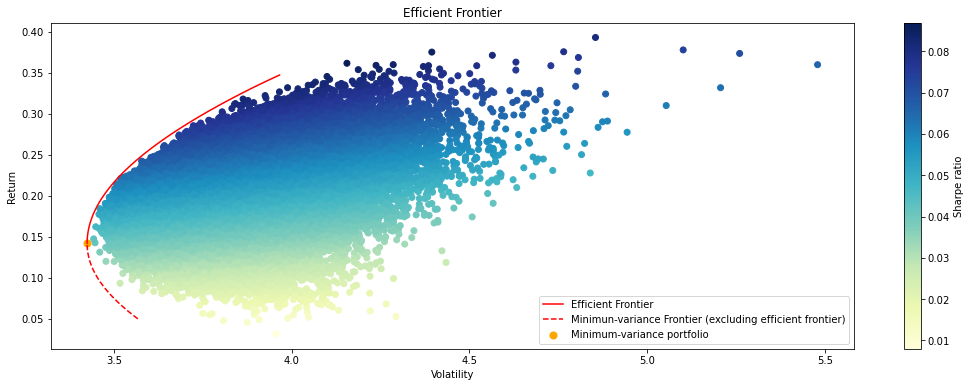

In [10]:
# calculate and plot the minimum-variance frontier
asset_returns_reshaped = np.reshape(asset_returns,(asset_returns.shape[0],1)) 

constraints = [{'type':'eq','fun': lambda x : sum(x) - 1},
              {'type':'eq','fun': lambda x : np.dot(x , asset_returns_reshaped) - u}]


x0 = np.array([1.0 / n_assets for x in range(n_assets)])

# get efficient frontier risk/returns
ef_mu_range = np.arange(min_var_mu[0],.35,.005)
ef_risk = []

for u in ef_mu_range:
    ef_portfolio  = solver.minimize(stddev,x0=x0,bounds=bounds,constraints=constraints)
    ef_risk.append(ef_portfolio.fun)

    
# get minimum-variance frontier risk/returns below the minimum variance portfolio
mvf_mu_range = np.arange(.05,min_var_mu[0],.005)
mvf_risk = []

for u in mvf_mu_range:
    mvf_portfolio  = solver.minimize(stddev,x0=x0,bounds=bounds,constraints=constraints)
    mvf_risk.append(mvf_portfolio.fun)   
    
sharpe_ratio = perf[:,0] / perf[:,1]   

# plot the Efficient Frontier and universe of simulated portfolios
plt.figure(figsize=(18,6))
plt.scatter(x = perf[:,1],y = perf[:,0],c=sharpe_ratio,cmap='YlGnBu')
plt.colorbar(label='Sharpe ratio')
plt.title('Efficient Frontier')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.plot(ef_risk,ef_mu_range,'r',label='Efficient Frontier')
plt.plot(mvf_risk,mvf_mu_range,'r--',label='Minimun-variance Frontier (excluding efficient frontier)')
plt.scatter([min_var_s[0]],[min_var_mu[0]],c='orange', s=50, label='Minimum-variance portfolio')
plt.legend(loc='lower right')
plt.show()

### Pyportfolioopt
Now that we have some understanding of what is going on under the hood, I will introduce Pyportfolioopt, a Python package for constructing optimised portfolios. I will first use Pyportfolioopt to calculate the annualised asset returns and the covariance matrix of the returns, and compare the results with the values obtained previously using plain old python code. 
I shall use the standard notation of mu and S used through out the pyportfolioopt documentation.

In [11]:
mu = mean_historical_return(data,compounding=False)
S = risk_models.sample_cov(data)

print('Annualised asset returns using pyportfolioopt')
print(mu)
print('\nAnnualised asset returns calculated manually')
print(asset_returns)

print('\n\nCovariance matrix of annualised asset returns using pyportfolioopt')
print(S)
print('\nCovariance matrix of annualised asset returns calculated manually')
print(cov_matrix * 252)

Annualised asset returns using pyportfolioopt
GOOG    0.243116
MSFT    0.316808
CSCO    0.135657
AMZN    0.441647
C       0.076865
TSLA    0.564858
GS      0.086755
XOM    -0.071303
BP      0.006275
dtype: float64

Annualised asset returns calculated manually
[ 0.24311641  0.31680778  0.13565666  0.44164683  0.07686502  0.56485783
  0.08675514 -0.07130269  0.00627464]


Covariance matrix of annualised asset returns using pyportfolioopt
          GOOG      MSFT      CSCO      AMZN         C      TSLA        GS  \
GOOG  0.073282  0.055435  0.039779  0.054994  0.047988  0.052628  0.043306   
MSFT  0.055435  0.078423  0.048800  0.057109  0.052452  0.061537  0.047976   
CSCO  0.039779  0.048800  0.072679  0.038475  0.053939  0.040890  0.045866   
AMZN  0.054994  0.057109  0.038475  0.097148  0.035719  0.061641  0.035011   
C     0.047988  0.052452  0.053939  0.035719  0.127036  0.059502  0.092476   
TSLA  0.052628  0.061537  0.040890  0.061641  0.059502  0.302838  0.055169   
GS    0.043306

Pyportfolioopt provides methods for commonly used portfolio optimisation processes, and allows you to easily perform complicated calculations. Below I calculate the asset returns using compounding and shrink the covariance matrix using the Ledoit Wolf methodology.

In [12]:
mu = mean_historical_return(data,compounding=True)
S = CovarianceShrinkage(data).ledoit_wolf()

ef = EfficientFrontier(mu, S, weight_bounds=(0,1))
weights = ef.max_sharpe()

#clean_weights() truncates tiny weights to zero and rounds the rest
cleaned_weights = ef.clean_weights()

print('Weights of sharpe perfolio')
print(cleaned_weights)

print('\nExpected performance')
expected_performance = ef.portfolio_performance(verbose=True)

Weights of sharpe perfolio
OrderedDict([('GOOG', 0.0), ('MSFT', 0.064), ('CSCO', 0.0), ('AMZN', 0.78957), ('C', 0.0), ('TSLA', 0.14643), ('GS', 0.0), ('XOM', 0.0), ('BP', 0.0)])

Expected performance
Expected annual return: 47.6%
Annual volatility: 29.7%
Sharpe Ratio: 1.54


In addition to providing a function to calc the sharpe portfolio, pyportfolioopt also provides functions to calc weights based on a target risk or target return.

In [13]:
ef = EfficientFrontier(mu, S, weight_bounds=(-1,1))

required_volatility = 0.4
required_return = 0.2

weights = ef.efficient_risk(required_volatility)
cleaned_weights = ef.clean_weights()

print('Weights of sharpe perfolio, specifing a required annual volitility of %.1f%% ' % (required_volatility * 100))
print(cleaned_weights)
print('\nExpected performance')
expected_performance = ef.portfolio_performance(verbose=True)

# calc efficient return
weights = ef.efficient_return(required_return)
cleaned_weights = ef.clean_weights()

print('\n\nWeights of sharpe perfolio, specifing a required annual return of %.1f%% ' % (required_return * 100))
print(cleaned_weights)
print('\nExpected performance')
expected_performance = ef.portfolio_performance(verbose=True)

Weights of sharpe perfolio, specifing a required annual volitility of 40.0% 
OrderedDict([('GOOG', -0.04614), ('MSFT', 0.58418), ('CSCO', -0.04818), ('AMZN', 0.88813), ('C', -0.10519), ('TSLA', 0.19036), ('GS', -0.07444), ('XOM', -0.4416), ('BP', 0.05289)])

Expected performance
Expected annual return: 73.5%
Annual volatility: 40.0%
Sharpe Ratio: 1.79


Weights of sharpe perfolio, specifing a required annual return of 20.0% 
OrderedDict([('GOOG', 0.17441), ('MSFT', 0.09875), ('CSCO', 0.20046), ('AMZN', 0.24589), ('C', -0.20484), ('TSLA', 0.02458), ('GS', 0.16108), ('XOM', 0.24271), ('BP', 0.05695)])

Expected performance
Expected annual return: 20.0%
Annual volatility: 21.5%
Sharpe Ratio: 0.84


A nice feature of Pyportfolioopt is that it can calculate the quantity of assets to buy/short for a given investment amount.

In [14]:
investment = 1e6
latest_prices = get_latest_prices(data)
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=investment)
allocation, leftover = da.lp_portfolio()
print('Asset allocation (buy/short) for an investment of ${:,.2f}' .format(investment))
print(allocation)
print('\nLeftover\n${:,.2f}' .format(leftover))

Asset allocation (buy/short) for an investment of $1,000,000.00
{'GOOG': 82, 'MSFT': 386, 'CSCO': 4042, 'AMZN': 65, 'TSLA': 41, 'GS': 596, 'XOM': 5387, 'BP': 2421, 'C': -5753}

Leftover
$1,317.85


### Bounds and sector constraints
In the previous example, weight_bounds was set equal to (-1,1). This sets the bounds for the optimiser, allowing negative weights. By default the weight bounds for the EfficientFrontier procedure are (0,1), i.e. long only. The weight bounds are similar to the bounds in the manually calculations above, a long short portfolio can be calculated by setting the lower bound to -1. Bounds can be used to set the minimum weights or maximum weights for each asset.  

note that the long-short portfolio has an improved sharpe ratio over the long-only portfolio calculated earlier

In [15]:
ef = EfficientFrontier(mu, S, weight_bounds=(-1,1))
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

print('Weights of sharpe perfolio when shorting is allowed')
print(cleaned_weights)

print('\nExpected performance of long-short portfolio')
expected_performance = ef.portfolio_performance(verbose=True)

Weights of sharpe perfolio when shorting is allowed
OrderedDict([('GOOG', -0.03895), ('MSFT', 1.0), ('CSCO', -0.1643), ('AMZN', 1.0), ('C', -0.07761), ('TSLA', 0.31546), ('GS', -0.20653), ('XOM', -0.8782), ('BP', 0.05014)])

Expected performance of long-short portfolio
Expected annual return: 101.6%
Annual volatility: 54.2%
Sharpe Ratio: 1.84


In addition to setting min and max allocations using the bounds parameter, sector constraints can be applied. 
When using the default cvxpy optimiser, sector constraints can only be applied to long-only portfolios.

In [25]:
# define sector mapping, and upper and lower sector bounds
sector_mapper = {
    'GOOG' : 'tech',
    'MSFT' : 'tech',
    'CSCO' : 'tech',
    'AMZN' : 'tech',
    'C' : 'financials',
    'TSLA' : 'tech',
    'GS' : 'financials',
    'XOM' : 'oil/gas',
    'BP' : 'oil/gas'
}

sector_lower = {'tech' : 0.3, 'financials' : 0.2, 'oil/gas' : 0.2}
sector_upper = {'tech' : 0.5}

ef = EfficientFrontier(mu, S, weight_bounds=(0.01,1))
ef.add_sector_constraints(sector_mapper = sector_mapper,sector_lower = sector_lower,sector_upper = sector_upper)
weights = ef.max_sharpe()
print(weights)


OrderedDict([('GOOG', 0.01), ('MSFT', 0.01), ('CSCO', 0.01), ('AMZN', 0.41718343927068), ('C', 0.01), ('TSLA', 0.05281656072932), ('GS', 0.29), ('XOM', 0.01), ('BP', 0.19)])


### Black-Litterman model

When it was first published in the Journal of Finance in 1952, Harry Markowitz's paper on “Portfolio Selection” set the foundations for Modern Portfolio Theory, emphasising the benefits of diversification. Markowitz used historical returns to calculate portfolio returns and the standard deviation of returns to measure risk. Since 1952 there has been a number of innovations in portfolio optimisation, not least the Sharpe ratio, developed by William F. Sharpe in 1966.

The Black–Litterman model was developed by Fischer Black and Robert Litterman at Goldman Sachs, and published in 1992. The Black-Litterman model takes a Baysian approach to estimating expected returns, taking both the investor's views of expected returns and the market view. The market view is usually the CAPM, however Pyportfolioopt's Black-Litterman model does not require you to give the CAPM. 

The investor view can be stated relatively, e.g. GOOG will outperform AMZN by 15%, or absolutely, e.g GOOG will return 20%. In the example below the investor views are set to some random absolute return. I can be seen that the Black-Litterman returns take into account the investor's views, with a noticable increase in expected returns for XOM and a decrease for AMZN.


In [24]:
from pypfopt import black_litterman
from pypfopt.black_litterman import BlackLittermanModel

investor_view = {
    'GOOG' : 0.20,
    'MSFT' : 0.10,
    'CSCO' : 0.20,
    'AMZN' : -0.10,
    'C' : 0.20,
    'TSLA' : 0.40,
    'GS' : -0.20,
    'XOM' : 0.20,
    'BP' : 0.20
} 

bl = BlackLittermanModel(S,absolute_views=investor_view)
bl_asset_returns = bl.bl_returns()

print(bl_asset_returns)

GOOG    0.099712
MSFT    0.087158
CSCO    0.113378
AMZN    0.020321
C       0.103989
TSLA    0.213766
GS      0.030173
XOM     0.125200
BP      0.137939
dtype: float64
